In [196]:
import torchvision
import numpy as np
import TensionFlow as tf
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import torch
import random
import math

In [2]:
train_data = torchvision.datasets.MNIST('data/', train=True)
test_data = torchvision.datasets.MNIST('data/', train=False)

In [3]:
train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data/
     Split: Train,
 Dataset MNIST
     Number of datapoints: 10000
     Root location: data/
     Split: Test)

In [4]:
def one_hot(x, classes=10):
    a = np.zeros((len(x), classes))
    for i in range(len(x)):
        a[i][x[i]] = 1
    return a

**TensionFlow**

In [5]:
f_in = 28*28
f_out = 10
h_layer = tf.Neuron(np.random.uniform(low=-np.sqrt(1/f_in), high=np.sqrt(1/f_in), size=(f_in, f_out)))
b_layer = tf.Neuron(np.random.uniform(low=-np.sqrt(1/f_in), high=np.sqrt(1/f_in), size=(1 , f_out)))

In [6]:
i = 0
batch_size = 64

In [7]:
inp = train_data.data[i:i+batch_size].reshape(batch_size,28*28) / 255
label = train_data.targets[i:i+batch_size]    
out = (tf.Neuron(inp.numpy()) @ h_layer) + (tf.Neuron(np.ones((batch_size,1))) @ b_layer)
# print(out.shape())
# out.backward()
e = out.exp()
# # e.backward()
e_s = e.sum(1)
# print(e.shape())
out_soft = e / (e_s @ tf.Neuron(np.ones((1,10))))
# print(out_soft.shape())
# out_soft.backward()
# print(out_soft.value.shape)

# oh_label = tf.Neuron(one_hot(label.numpy()))

# loss = -(out_soft * oh_label).sum().log().sum(0)
# loss.backward()

In [8]:
#defining model
f_in = 28*28
f_out = 10
h_layer = tf.Neuron(np.random.uniform(low=-np.sqrt(1/f_in), high=np.sqrt(1/f_in), size=(f_in, f_out)))
b_layer = tf.Neuron(np.random.uniform(low=-np.sqrt(1/f_in), high=np.sqrt(1/f_in), size=(1 , f_out)))

In [9]:
lr = 1e-6

In [10]:
lossi = []
test_lossi = []

In [11]:
epochs = 10

In [12]:
batch_size = 256

In [13]:
for e in tqdm(range(epochs)):
    for i in range(0,len(train_data), batch_size):
#         print(train_data.data[i:i+batch_size].shape)
        current_batch_size = train_data.data[i:i+batch_size].shape[0]
        inp = train_data.data[i:i+batch_size].reshape(current_batch_size,28*28) / 255
        label = train_data.targets[i:i+batch_size]    
        
        out = (tf.Neuron(inp.numpy()) @ h_layer) + (tf.Neuron(np.ones((current_batch_size,1))) @ b_layer)
        e = out.exp()
        e_s = e.sum(1)
        out_soft = e / (e_s @ tf.Neuron(np.ones((1,10))))
        
        oh_label = tf.Neuron(one_hot(label.numpy()))
        
        loss = -(out_soft * oh_label).sum().log().sum(0)
        loss.backward()
        h_layer.value -= h_layer.grad * lr
        b_layer.value -= b_layer.grad.sum(0) * lr
        lossi.append(loss.value[0][0])
        loss.backward_zero_grad()
#         print(loss)
    
    for i in range(0,len(test_data), batch_size):
        current_batch_size = test_data.data[i:i+batch_size].shape[0]
        
        inp = test_data.data[i:i+batch_size].reshape(current_batch_size,28*28) / 255
        label = test_data.targets[i:i+batch_size]    
        
        out = (tf.Neuron(inp.numpy()) @ h_layer) + (tf.Neuron(np.ones((current_batch_size,1))) @ b_layer)
        e = out.exp()
        e_s = e.sum(1)
        out_soft = e / (e_s @ tf.Neuron(np.ones((1,10))))
        oh_label = tf.Neuron(one_hot(label.numpy()))
        loss = -(out_soft * oh_label).sum().log().sum(0)
        test_lossi.append(loss.value[0][0])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:07<00:00, 12.71s/it]


In [35]:
len(test_lossi)

400

In [40]:
len(lossi) / len(test_lossi)

5.875

In [38]:
len(test_lossi)

400

In [39]:
len(lossi) / 5

470.0

In [187]:
len(test_lossi)

400

In [195]:
len(x)

470

In [199]:
x[-1]

2346

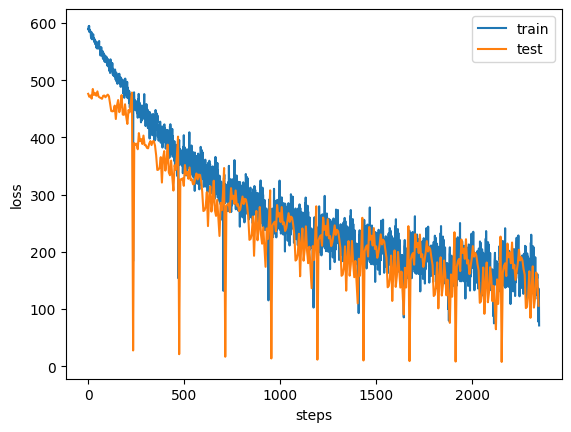

In [200]:
plt.plot(lossi[:])
x = list(range(0,len(lossi), math.ceil(len(lossi)/len(test_lossi))))
plt.plot(x, test_lossi[:len(x)])
plt.xlabel('steps')
plt.ylabel('loss')
plt.legend(['train', 'test'])
plt.show()

In [189]:
#accuracy
correct = 0
for i in range(0,len(test_data)//batch_size):
    current_batch_size = test_data.data[i:i+batch_size].shape[0]
    inp = test_data.data[i:i+batch_size].reshape(current_batch_size,28*28) / 255
    label = test_data.targets[i:i+batch_size]    

    out = (tf.Neuron(inp.numpy()) @ h_layer) + (tf.Neuron(np.ones((current_batch_size,1))) @ b_layer)
    e = out.exp()
    e_s = e.sum(1)
    out_soft = e / (e_s @ tf.Neuron(np.ones((1,10))))
    correct += (out_soft.argmax(1) == label.numpy()).sum()
#     loss = -(out_soft * oh_label).sum().log().sum(0)
#     test_lossi.append(loss.value[0][0])

In [17]:
correct/ len(test_data)

0.8114

In [31]:
#accuracy
correct = 0
for i in range(0,len(train_data)//batch_size):
    current_batch_size = train_data.data[i:i+batch_size].shape[0]
    inp = train_data.data[i:i+batch_size].reshape(current_batch_size,28*28) / 255
    label = train_data.targets[i:i+batch_size]    

    out = (tf.Neuron(inp.numpy()) @ h_layer) + (tf.Neuron(np.ones((current_batch_size,1))) @ b_layer)
    e = out.exp()
    e_s = e.sum(1)
    out_soft = e / (e_s @ tf.Neuron(np.ones((1,10))))
    correct += (out_soft.argmax(1) == label.numpy()).sum()
#     loss = -(out_soft * oh_label).sum().log().sum(0)
#     test_lossi.append(loss.value[0][0])

In [33]:
correct/ len(train_data)

0.8443833333333334

Pred: 1 grad: None, label: 1


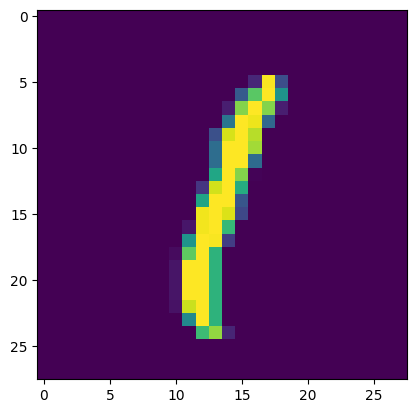

In [159]:
i = random.randint(0,len(test_data))
#inference
inp = test_data.data[i].reshape(1,28*28) / 255
label = test_data.targets[i]    

out = (tf.Neuron(inp.numpy()) @ h_layer) + (tf.Neuron(np.ones((1,1))) @ b_layer)
e = out.exp()
e_s = e.sum(1)
out_soft = e / (e_s @ tf.Neuron(np.ones((1,10))))
print(f'Pred: {out_soft.argmax()}, label: {label}')
plt.imshow(test_data.data[i])
